In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import dataset
import numbs
import tree_search
import backprop
import lpbackprop
import jump_backprop
import constraints
import utils

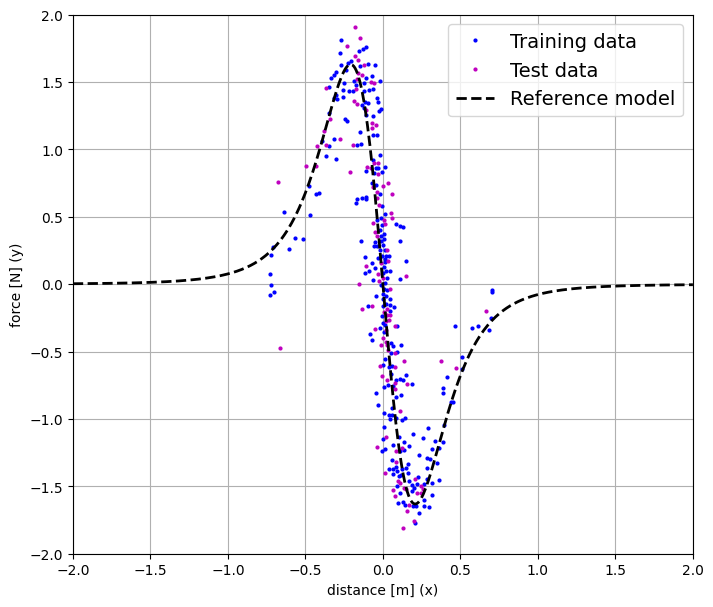

In [2]:
S = dataset.MagmanDatasetScaled()
#S.sample(size=250, noise=0.03, mesh=False)
S.load('../data/magman.csv')
S.split()
S.plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S.index()
numbs.init(S)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
#stree     = backprop.SyntaxTreeGenerator().create_random(5)[0]
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * B(x)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_eval = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_eval
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, unkn_model_d1, unkn_model_d2, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()

    hist, __best_unkn_models, __best_eval = jump_backprop.jump_backprop(stree, stree_pr, stree_pr2, synth_unkn_models, S_train, S_test, max_rounds=1)
    hist_set.append(hist)

    if best_eval is None or __best_eval.better_than(best_eval):
        best_unkn_models = __best_unkn_models
        best_eval = __best_eval

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)

--- On Synth ---
A(x) =
 
1 x
B(x) =
    6     4
-1 x - 1 x - 1

--- On Synth ---
A(x) =
   5     3
1 x + 1 x + 1 x
B(x) =
    6     4
-1 x - 1 x - 1

--- On Synth ---
A(x) =
 
-1 x
B(x) =
   6     4
1 x + 1 x + 1

--- On Synth ---
A(x) =
    5     3
-1 x - 1 x - 1 x
B(x) =
   6     4
1 x + 1 x + 1



(True, <lpbackprop.AspModelCost at 0x1cb1bc639d0>)

--- Best Syntax Tree ---


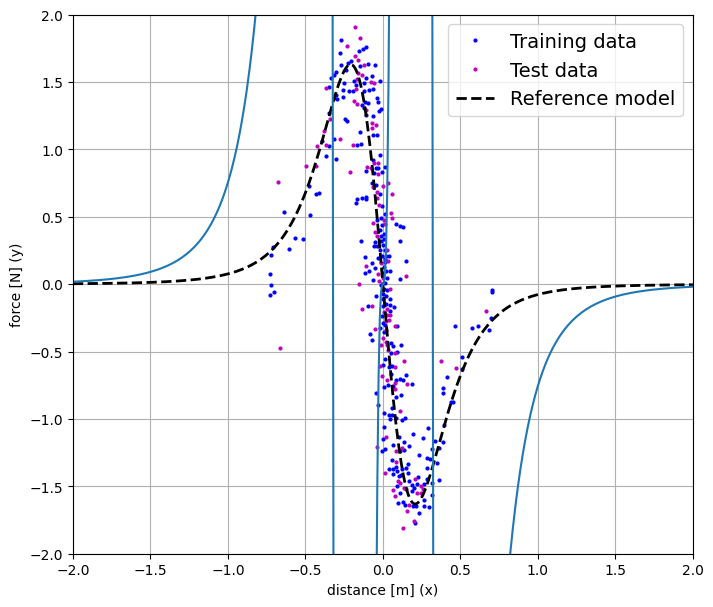

{'mse0': 8.156342585553437e-05, 'mse1': 0.028720122106932363, 'mse2': 31.031063032912325}


In [5]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_eval is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
import sympy
#print(sympy.print_latex(stree.to_sympy()))
#print(best_eval)
S.plot(width=8, height=7)
xp = np.linspace(S.xl, S.xu, 500)
plt.plot(xp, stree_pr2.compute_output(xp));
plt.show()

k_eval = S.knowledge.evaluate((stree.compute_output, stree_pr.compute_output, stree_pr2.compute_output))
print(k_eval)


--- Pull from A(x) ---


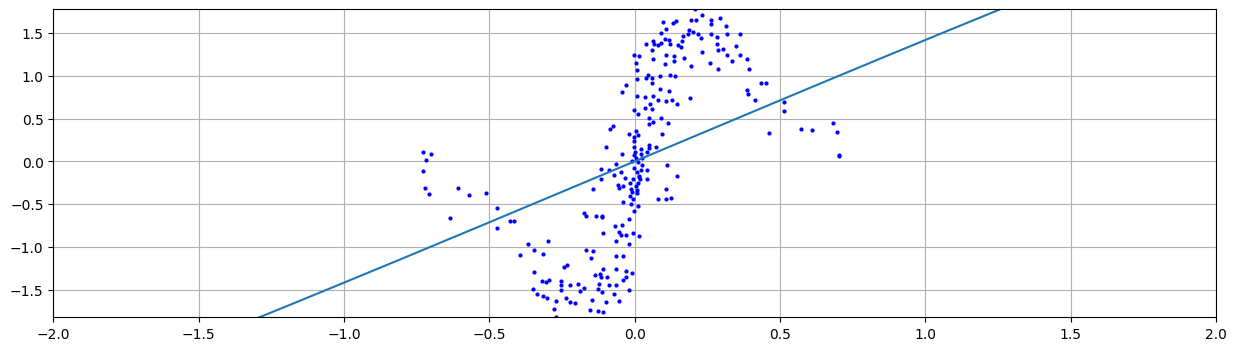

Model:
           5            3
2.852e-05 x - 0.009506 x + 1.426 x
Coeffs Softmax:
[0.11502505 0.11502733 0.11502505 0.11426581 0.11502505 0.31060667
 0.11502505]
Coeffs:
[ 0.00000000e+00  2.85180357e-05  0.00000000e+00 -9.50601192e-03
  0.00000000e+00  1.42590180e+00  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---


TypeError: 'method' object is not subscriptable

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if not hist_entry.pulled_S.is_empty():
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.plot(width=15, height=4, plotref=False)
        xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        plt.show()
        #model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        model = hist_entry.fit_model
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.c)}")
        print(f"Coeffs:\n{model.c}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = str(dp.y) #"{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    model_eval = S.evaluate(stree.compute_output)
    print(model_eval)
    
    S.plot(width=8, height=7)
    xp = np.linspace(S.xl, S.xu, 500)
    plt.plot(xp, stree.compute_output(xp));
    plt.show()

    print()